In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import data_cleaning as dc
import data_preprocessing as dp
import feature_engineering as fe
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import time


Columns with missing values and their counts before preprocessing:
Alley           2593
MasVnrType      1629
MasVnrArea        21
BsmtQual          64
BsmtCond          64
BsmtExposure      67
BsmtFinType1      64
BsmtFinType2      65
Electrical         1
FireplaceQu     1277
PoolQC          2756
Fence           2227
MiscFeature     2671
dtype: int64

Columns with missing values after imputation and their counts:
Series([], dtype: int64)

The dataset contains 2769 rows and 80 columns before outlier removal.
Number of rows removed based on 'GrLivArea' > 4000: 5

The dataset contains 2764 rows and 80 columns after outlier removal.
Categorical variables encoded.
Numerical features standardized.
'SalePrice' standardized.
Explained variance ratio: 0.9513195107448541
PCA Training Time: 1.73 seconds
Training Time for RFE: 111.51 seconds
Model Performance:
Mean Absolute Error (MAE): $31365.36
Mean Squared Error (MSE): $2192136078.70
Training Time: 0.00 seconds
Lasso Performance:
Mean Absolute

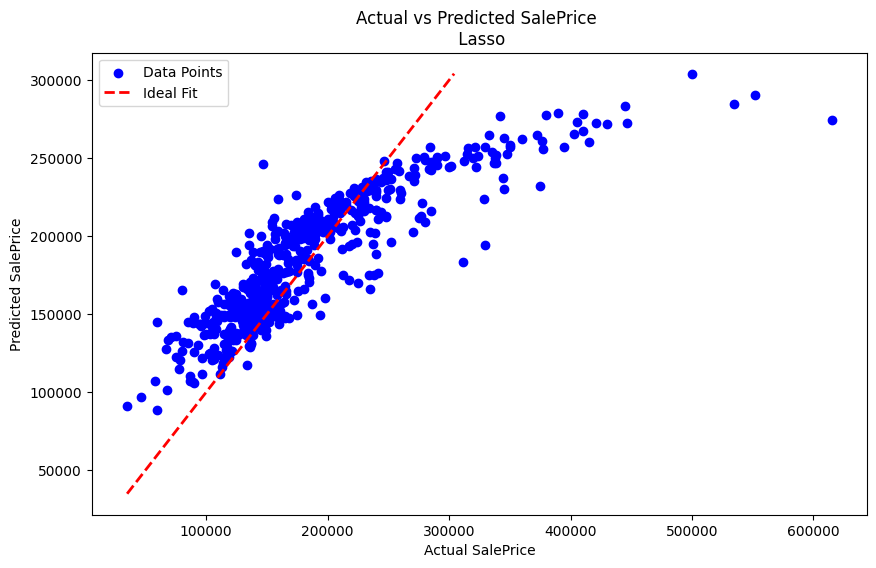

In [2]:
# Load and clean the data
file_path = 'data/AmesData.csv'
ames_df_cleaned = dc.load_and_clean_data(file_path)

# Preprocess the cleaned data
ames_df_preprocessed, saleprice_scaler = dp.preprocess_data(ames_df_cleaned)

# Prepare features and target variable
X = ames_df_preprocessed.drop(['SalePrice'], axis=1)
y = ames_df_preprocessed['SalePrice']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply PCA
X_train_pca, pca = fe.apply_pca(X_train, explained_variance=0.95)
X_test_pca = pca.transform(X_test)

# Apply RFE
X_train_rfe, rfe = fe.apply_rfe(X_train_pca, y_train, n_features=50)
X_test_rfe = rfe.transform(X_test_pca)

# Select the model - this part changes for each model notebook
model = Lasso()

# Evaluate the model using the existing function
mae, mse, training_time, y_pred_original, y_test_original = fe.evaluate_model(model, X_train_rfe, X_test_rfe, y_train, y_test, saleprice_scaler)

print(f"{model.__class__.__name__} Performance:")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Squared Error (MSE): ${mse:.2f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_original.max()], [y_test_original.min(), y_pred_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title(f'Actual vs Predicted SalePrice \n {model.__class__.__name__}')
plt.legend()
plt.show()

# Feature Importance Visualization (if applicable)
# For models that support feature importance, visualize the top 50 features based on the original features
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_
    
    # Get the selected PCA components from RFE
    selected_pca_indices = rfe.get_support(indices=True)
    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=X.columns)
    selected_components = loadings_df.iloc[:, selected_pca_indices]
    
    # Aggregate the contributions of original features for the selected PCA components
    selected_feature_contributions = selected_components.abs().sum(axis=1).sort_values(ascending=False)
    
    # Select the top 50 features
    top_50_features = selected_feature_contributions.head(50)
    
    # Plot feature importances based on the top 50 original features
    plt.figure(figsize=(14, 10))
    sns.barplot(x=top_50_features.values, y=top_50_features.index)
    plt.title('Top 50 Feature Importances in Random Forest Regressor with Mapped Original Features')
    plt.xlabel('Importance')
    plt.ylabel('Original Features')
    plt.show()


Tuning

Lasso Regression Performance with RFE:
Mean Absolute Error (MAE): $17177.80
Mean Squared Error (MSE): $609817627.22
Training Time: 0.20 seconds
Best Parameters: {'alpha': 0.001}


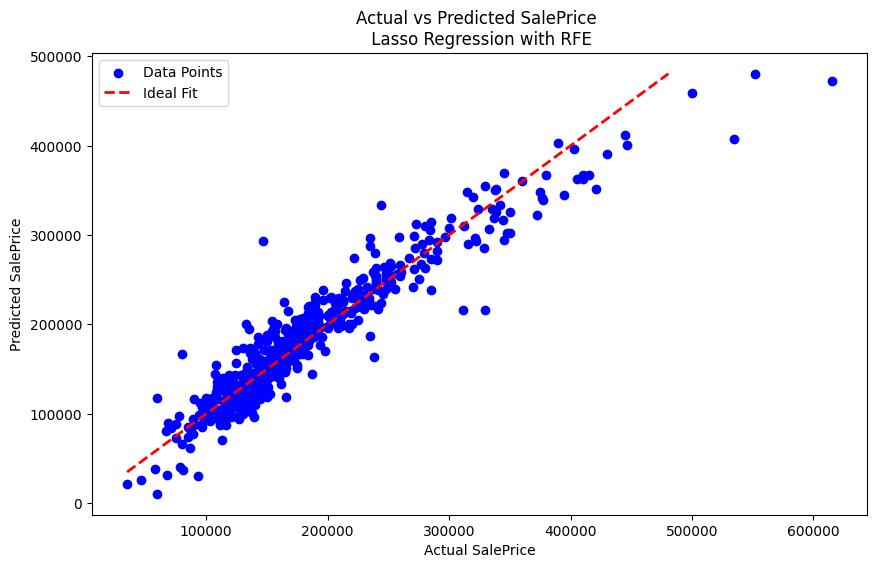

In [3]:
# Define the Lasso Regression model
lasso = Lasso()

# Hyperparameter tuning for Lasso Regression
param_grid_lasso = {'alpha': np.logspace(-6, 6, 13)}

lasso_search = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')

start_time_lasso = time.time()
lasso_search.fit(X_train_rfe, y_train)
end_time_lasso = time.time()

# Best parameters from tuning
best_params_lasso = lasso_search.best_params_

# Train the final Lasso Regression model with the best parameters
lasso_optimized = Lasso(**best_params_lasso)
lasso_optimized.fit(X_train_rfe, y_train)

# Make predictions
y_pred_lasso = lasso_optimized.predict(X_test_rfe)

# Un-transform the predictions back to the original scale
y_pred_lasso_original = saleprice_scaler.inverse_transform(y_pred_lasso.reshape(-1, 1)).flatten()

# Evaluate the model
mae_lasso = mean_absolute_error(y_test_original, y_pred_lasso_original)
mse_lasso = mean_squared_error(y_test_original, y_pred_lasso_original)

print("Lasso Regression Performance with RFE:")
print(f"Mean Absolute Error (MAE): ${mae_lasso:.2f}")
print(f"Mean Squared Error (MSE): ${mse_lasso:.2f}")
print(f"Training Time: {end_time_lasso - start_time_lasso:.2f} seconds")
print(f"Best Parameters: {best_params_lasso}")

# Plot predicted vs. actual for Lasso Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred_lasso_original, color='blue', label='Data Points')
plt.plot([y_test_original.min(), y_pred_lasso_original.max()], [y_test_original.min(), y_pred_lasso_original.max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Actual vs Predicted SalePrice \n Lasso Regression with RFE')
plt.legend()
plt.show()